# Imports

In [ ]:
!pip install --no-cache-dir transformers huggingface_hub torchaudio soundfile --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 190.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 151.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 238.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 188.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 206.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 189.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00


In [ ]:
!pip install --quiet git+https://github.com/speechbrain/speechbrain.git@develop

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 17.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/')

import torchaudio

from speechbrain.pretrained import EncoderClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
# Performance metrics
def per_class_accuracy(preds, labels, countries_classes):
    preds = np.array(preds)
    labels = np.array(labels)

    accs = []
    for i in range(len(countries_classes)):
        cls = countries_classes[i]
        idxs = labels == cls
        if idxs.sum() == 0:
            accs.append(np.nan)
        else:
            accs.append((preds[idxs] == labels[idxs]).mean())
    return accs

# Read in data

Clean data

In [ ]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')

# Clean up labels
countries = np.array(df['country'])
scripts = np.array(df['transcript'])
audio_paths = np.array(df['path'])
mask = np.array([len(countries[ind].split(',')) == 1 for ind in range(len(countries))], dtype=bool) # remove samples from multiple countries
countries, scripts, audio_paths = countries[mask], scripts[mask], audio_paths[mask]
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'
counts = df['country'].value_counts()

df_data = pd.DataFrame({'path': audio_paths, 'script': scripts, 'country': countries})
df_data['country'] = df_data['country'].apply(lambda x: x if counts[x] >= 2 else 'other') # classifies accents with <2 samples as "other"
df_data = df_data[df_data['country'] != 'other']
df_data = df_data.reset_index(drop=True)

# Encode labels
codes, uniques = pd.factorize(df_data['country'])
df_data['country_encoded'] = codes
mapping = {country: idx for idx, country in enumerate(uniques)}
inverse_mapping = {v: k for k, v in mapping.items()}

print("Mapping:", mapping)
df_data.head()

Mapping: {'usa': 0, 'uk': 1, 'australia': 2, 'canada': 3, 'new zealand': 4, 'south africa': 5, 'ireland': 6, 'jamaica': 7, 'singapore': 8}


,path,script,country,country_encoded
0,SpeechAccentArchive/english1.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa,0
1,SpeechAccentArchive/english2.mp3,\r\nPlease call Stella. Ask her to bring thes...,uk,1
2,SpeechAccentArchive/english3.mp3,\r\nPlease call Stella. Ask her to bring thes...,australia,2
3,SpeechAccentArchive/english5.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa,0
4,SpeechAccentArchive/english6.mp3,\r\nPlease call Stella. Ask her to bring thes...,usa,0


In [ ]:
accents_model = []

for ind in range(len(df_data)):
  script = df_data['script'][ind]
  audio_path = df_data['path'][ind]

  # Load the MP3 file
  signal, sr = torchaudio.load(audio_path)

  # # Resample to 16kHz if needed
  # if sr != 16000:
  #     resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
  #     signal = resampler(signal)

  # # Save as temporary WAV for classification
  # torchaudio.save("temp.wav", signal, 16000)

  # Load the ECAPA-TDNN based accent classifier
  classifier = EncoderClassifier.from_hparams(
      source="Jzuluaga/accent-id-commonaccent_ecapa",
      savedir="pretrained_models/accent-id-ecapa"
  )

  # Classify the audio
  out_prob, score, index, text_lab = classifier.classify_file(audio_path)

  # Save results
  accents_model.append(text_lab[0])
  print(f"{ind}/{len(df)}: {text_lab[0]}")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

0/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

1/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

2/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

3/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

4/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

5/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

6/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

7/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

8/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

9/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

10/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

11/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

12/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

13/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

14/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

15/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

16/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

17/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

18/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

19/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

20/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

21/661: us


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch accent_encoder.txt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learni

22/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

23/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

24/661: us


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch accent_encoder.txt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learni

25/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

26/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

27/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

28/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

29/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

30/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

31/661: indian


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

32/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

33/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

34/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

35/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

36/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

37/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

38/661: us


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch accent_encoder.txt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learni

39/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

40/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

41/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

42/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

43/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

44/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

45/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

46/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

47/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

48/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

49/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

50/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

51/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

52/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

53/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

54/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

55/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

56/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

57/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

58/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

59/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

60/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

61/661: scotland


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

62/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

63/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

64/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

65/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

66/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

67/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

68/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

69/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

70/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

71/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

72/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

73/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

74/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

75/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

76/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

77/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

78/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

79/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

80/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

81/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

82/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

83/661: us


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch accent_encoder.txt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learni

84/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

85/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

86/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

87/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

88/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

89/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

90/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

91/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

92/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

93/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

94/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

95/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

96/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

97/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

98/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

99/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

100/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

101/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

102/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

103/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

104/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

105/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

106/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

107/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

108/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

109/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

110/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

111/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

112/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

113/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

114/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

115/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

116/661: scotland


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

117/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

118/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

119/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

120/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

121/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

122/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

123/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

124/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

125/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

126/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

127/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

128/661: newzealand


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

129/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

130/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

131/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

132/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

133/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

134/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

135/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

136/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

137/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

138/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

139/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

140/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

141/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

142/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

143/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

144/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

145/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

146/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

147/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

148/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

149/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

150/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

151/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

152/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

153/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

154/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

155/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

156/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

157/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

158/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

159/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

160/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

161/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

162/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

163/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

164/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

165/661: scotland


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

166/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

167/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

168/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

169/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

170/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

171/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

172/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

173/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

174/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

175/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

176/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

177/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

178/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

179/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

180/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

181/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

182/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

183/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

184/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

185/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

186/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

187/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

188/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

189/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

190/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

191/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

192/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

193/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

194/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

195/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

196/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

197/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

198/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

199/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

200/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

201/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

202/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

203/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

204/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

205/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

206/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

207/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

208/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

209/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

210/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

211/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

212/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

213/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

214/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

215/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

216/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

217/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

218/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

219/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

220/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

221/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

222/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

223/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

224/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

225/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

226/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

227/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

228/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

229/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

230/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

231/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

232/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

233/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

234/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

235/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

236/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

237/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

238/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

239/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

240/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

241/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

242/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

243/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

244/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

245/661: african


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

246/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

247/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

248/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

249/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

250/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

251/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

252/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

253/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

254/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

255/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

256/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

257/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

258/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

259/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

260/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

261/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

262/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

263/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

264/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

265/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

266/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

267/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

268/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

269/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

270/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

271/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

272/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

273/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

274/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

275/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

276/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

277/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

278/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

279/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

280/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

281/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

282/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

283/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

284/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

285/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

286/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

287/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

288/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

289/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

290/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

291/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

292/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

293/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

294/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

295/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

296/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

297/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

298/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

299/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

300/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

301/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

302/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

303/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

304/661: scotland


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

305/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

306/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

307/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

308/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

309/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

310/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

311/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

312/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

313/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

314/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

315/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

316/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

317/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

318/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

319/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

320/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

321/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

322/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

323/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

324/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

325/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

326/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

327/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

328/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

329/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

330/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

331/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

332/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

333/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

334/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

335/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

336/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

337/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

338/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

339/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

340/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

341/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

342/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

343/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

344/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

345/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

346/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

347/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

348/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

349/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

350/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

351/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

352/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

353/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

354/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

355/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

356/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

357/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

358/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

359/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

360/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

361/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

362/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

363/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

364/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

365/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

366/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

367/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

368/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

369/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

370/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

371/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

372/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

373/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

374/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

375/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

376/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

377/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

378/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

379/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

380/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

381/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

382/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

383/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

384/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

385/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

386/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

387/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

388/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

389/661: scotland


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

390/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

391/661: african


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

392/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

393/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

394/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

395/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

396/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

397/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

398/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

399/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

400/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

401/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

402/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

403/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

404/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

405/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

406/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

407/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

408/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

409/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

410/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

411/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

412/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

413/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

414/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

415/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

416/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

417/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

418/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

419/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

420/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

421/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

422/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

423/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

424/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

425/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

426/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

427/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

428/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

429/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

430/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

431/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

432/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

433/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

434/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

435/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

436/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

437/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

438/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

439/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

440/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

441/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

442/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

443/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

444/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

445/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

446/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

447/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

448/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

449/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

450/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

451/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

452/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

453/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

454/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

455/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

456/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

457/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

458/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

459/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

460/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

461/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

462/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

463/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

464/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

465/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

466/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

467/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

468/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

469/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

470/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

471/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

472/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

473/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

474/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

475/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

476/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

477/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

478/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

479/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

480/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

481/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

482/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

483/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

484/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

485/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

486/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

487/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

488/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

489/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

490/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

491/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

492/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

493/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

494/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

495/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

496/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

497/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

498/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

499/661: australia


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

500/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

501/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

502/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

503/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

504/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

505/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

506/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

507/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

508/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

509/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

510/661: england


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

511/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

512/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

513/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

514/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

515/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

516/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

517/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

518/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

519/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

520/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

521/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

522/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

523/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

524/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

525/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

526/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

527/661: canada


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

528/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

529/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

530/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

531/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

532/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

533/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

534/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

535/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

536/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

537/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

538/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

539/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

540/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

541/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

542/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

543/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

544/661: bermuda


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

545/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

546/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

547/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

548/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

549/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

550/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

551/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

552/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

553/661: australia


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

554/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

555/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

556/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

557/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

558/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

559/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

560/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

561/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

562/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

563/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

564/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

565/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

566/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

567/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

568/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

569/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

570/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

571/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

572/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

573/661: canada


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

574/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

575/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

576/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

577/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

578/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

579/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

580/661: us


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt
INFO

581/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

582/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

583/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

584/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

585/661: england


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

586/661: us


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/hyperparams.yaml'
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/accent-id-ecapa.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/pretrained_models/accent-id-ecapa/classifier.ckpt'
DEBUG:spee

587/661: us


Model performance

In [ ]:
accents_model_sample not in countries

False

accuracy: 0.7891156462585034


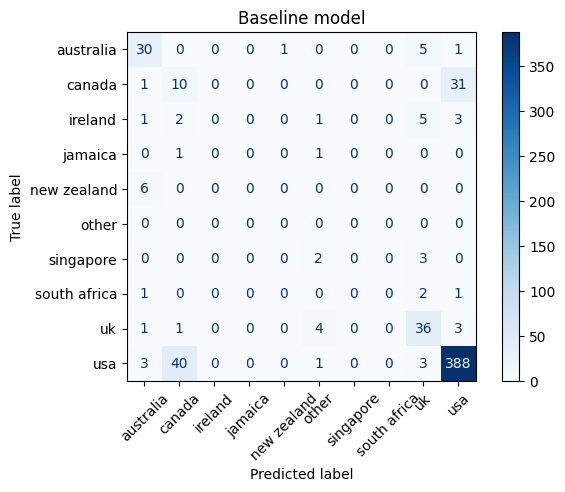

In [ ]:
countries = np.array(df_data['country'])
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'

accents_model_sample = np.array(accents_model)
accents_model_sample = accents_model_sample.astype(object)
accents_model_sample[accents_model_sample == 'us'] = 'usa'
accents_model_sample[accents_model_sample == 'england'] = 'uk'
accents_model_sample[accents_model_sample == 'newzealand'] = 'new zealand'
mask = np.isin(accents_model_sample, countries)
accents_model_sample[~mask] = 'other'

print(f"accuracy: {np.sum(accents_model_sample == countries)/len(countries)}")

labels = sorted(list(set(countries) | set(accents_model_sample)))  # union of both sets
cm = confusion_matrix(countries, accents_model_sample)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.title('Pretrained model on Speech Accent Archive')
plt.show()

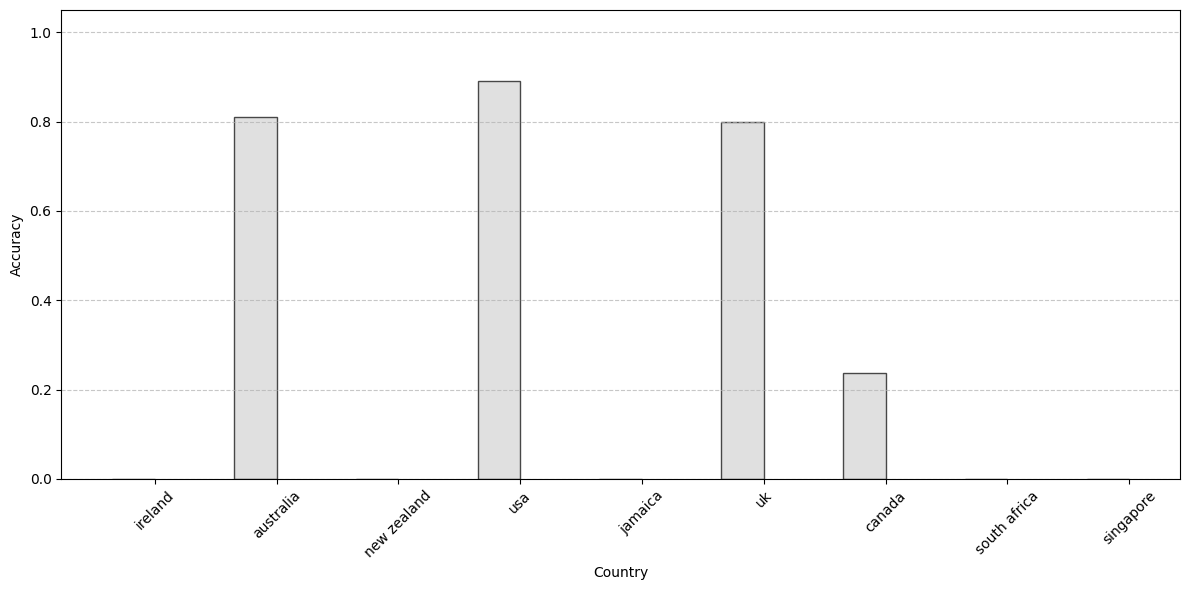

In [ ]:
# Compute accuracy for each accent
countries_classes = list(set(countries))
accs = per_class_accuracy(accents_model_sample, countries, countries_classes)

# X-axis labels
x = np.arange(num_countries)
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, accs, width, color='lightgray', alpha=0.7, edgecolor='k')
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(x, countries_classes, rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

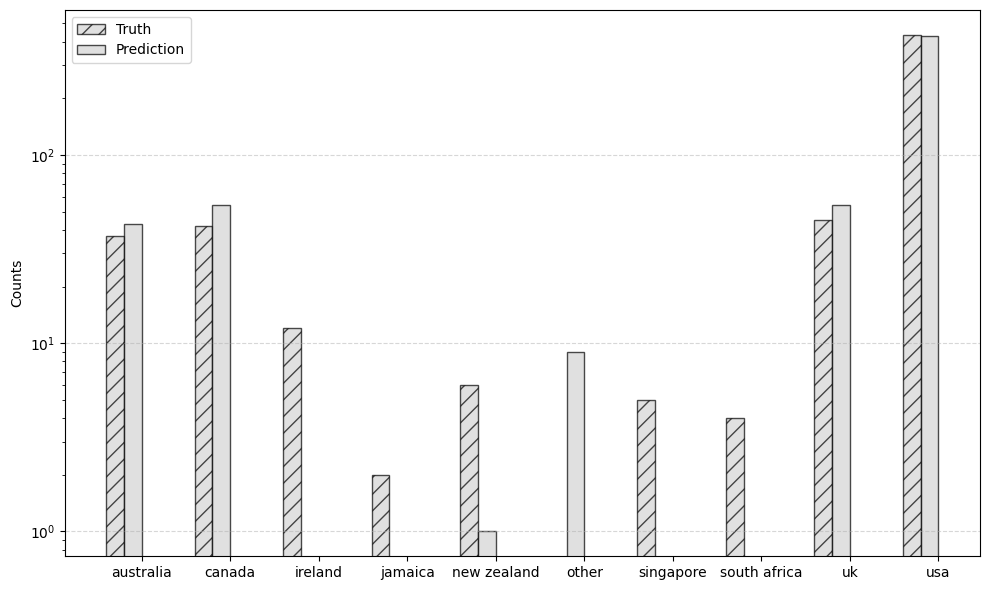

In [ ]:
labels_counts = pd.DataFrame(countries).value_counts()
preds_counts = pd.DataFrame(accents_model_sample).value_counts()

labels_counts.index = [i[0] if isinstance(i, tuple) else i for i in labels_counts.index]
preds_counts.index = [i[0] if isinstance(i, tuple) else i for i in preds_counts.index]

df = pd.DataFrame({
    'Labels': labels_counts,
    'Preds': preds_counts
})

labels = df.index.tolist()
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bars_train_labels = ax.bar(x - 1.5*width, df['Labels'], width, color='lightgray', label='Truth', hatch='//', alpha=0.7, edgecolor='k')
bars_train_preds = ax.bar(x - 0.5*width, df['Preds'], width, color='lightgray', label='Prediction', alpha=0.7, edgecolor='k')

ax.set_yscale('log')
ax.set_ylabel('Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()